# Load Libraries and Data

In [1]:
library(Matrix)
library(dplyr)
library(Seurat)
library(ggplot2)
library(edgeR)
library(RColorBrewer)
library(scales)

##color schemes
bw.dark = "#AC660C"
bw.light = "#F1A039"

po.dark = "#1D237E"
po.light = "#6E94E6"


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, will retire in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.
The sp package is now running under evolution status 2
     (status 2 uses the sf package in place of rgdal)

Attaching SeuratObject

Loading required package: limma



In [2]:
## gene annotations

genes_annot = read.table("all_genes.annotated.20241801.list", header=T)

col = c("gray", "#F27457", "#BF665E", "#6A8C69", "#A8B545","#13678A","#53736A")
names(col) = names(table(genes_annot$annotation))



## Load clustered data

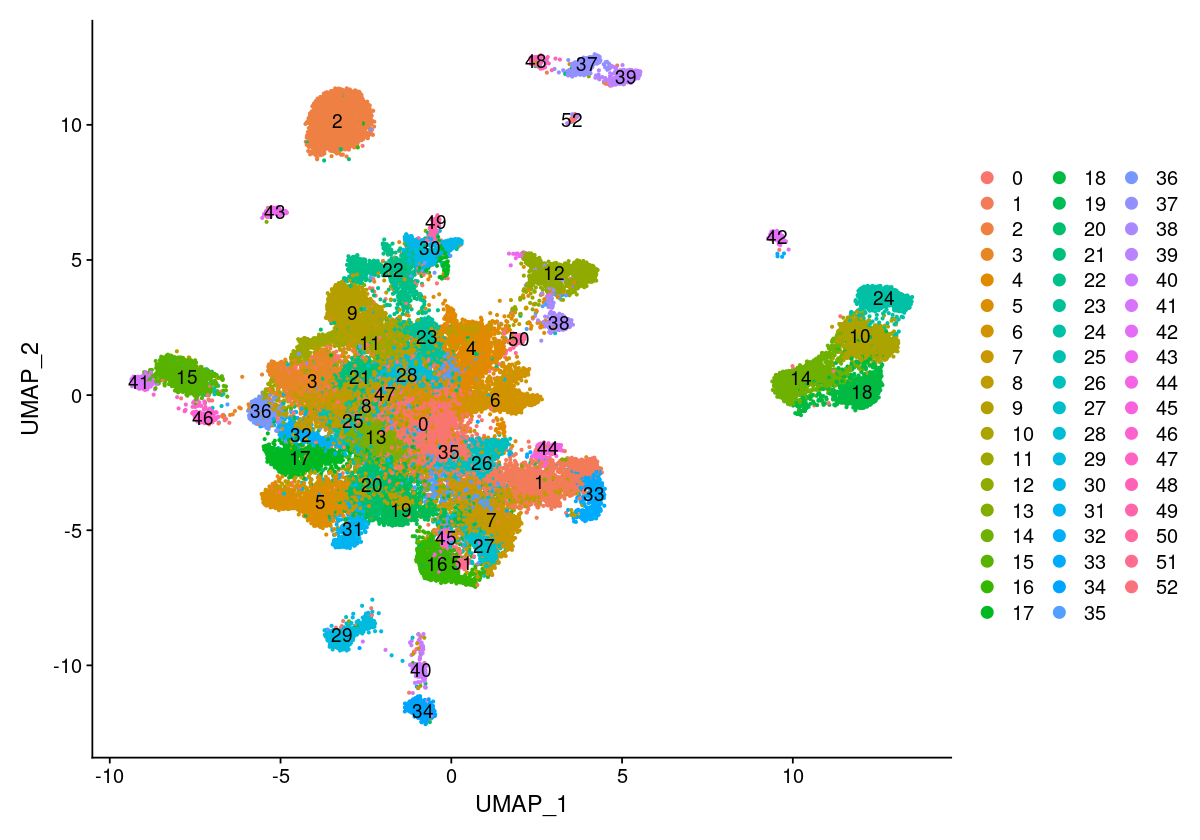

In [3]:
##downlad RDS file from GEO GSE272719
neurons.clustered = readRDS(file="neurons.clustered.rds")
options(repr.plot.width=10, repr.plot.height=7)
DimPlot(neurons.clustered, reduction = "umap", label=T, pt.size=.5)


# Differential Abundance

In [4]:
##set up edgeR using cell cluster counts as counts

neurons.clusters = Idents(neurons.clustered)

lib.size = table(apply(neurons.clustered@meta.data, 1, function(x) paste0(x[4], x[5],
    x[6])))

samples = data.frame(lib.size = table(apply(neurons.clustered@meta.data, 1, function(x) paste0(x[4],
    x[5], x[6]))), species = unname(sapply(names(lib.size), function(x) substr(x,
    1, 2))), sex = sapply(names(lib.size), function(x) substr(x, 3, 3)), rep = sapply(names(lib.size),
    function(x) substr(x, 4, 8)), parent = c(rep("Y", 6), rep("N", 6), rep("Y",12)))
samples = samples[, 2:6]
colnames(samples) = c("lib.size", "species", "sex", "rep", "parent")


counts = c()
for (cluster in unique(Idents(neurons.clustered))) {

    tmp = subset(neurons.clustered, idents = cluster)
    tmp.meta = tmp@meta.data

    b = table(apply(tmp.meta, 1, function(x) paste0(x[4], x[5], x[6])))
    counts = rbind(counts, b[names(lib.size)])
}
rownames(counts) = unique(neurons.clusters)
colnames(counts) = names(lib.size)
counts[is.na(counts)] = 0
edger.data = DGEList(counts, samples = samples)
design <- model.matrix(~rep +species+ sex, samples)
edger.data = estimateDisp(edger.data, design, trend="none")
edger.data = calcNormFactors(edger.data)
fit = glmQLFit(edger.data, design)
                    

In [7]:
##test differential abundance across sex
res = glmQLFTest(fit, coef=ncol(design))
da_sex = res$table
da_sex = cbind(res$table, fdr = p.adjust(da_sex$PValue))
head(da_sex[order(da_sex$PValue),])


,logFC,logCPM,F,PValue,fdr
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
9,0.8297977,15.04075,22.320686,0.0001238751,0.006565383
5,0.5987636,15.18929,9.815780,0.0051528071,0.267945970
0,0.5625421,15.98897,5.190452,0.0336158308,1.000000000
27,-0.3321833,13.89441,4.170084,0.0542956065,1.000000000
51,-0.8458341,11.49519,3.907534,0.0617555604,1.000000000
16,-0.2607925,14.60257,2.964717,0.1002407180,1.000000000


In [8]:
##test differential abundance across species 
res = glmQLFTest(fit, coef=ncol(design)-1)
da_species = res$table
da_species = cbind(res$table, fdr = p.adjust(da_species$PValue))
head(da_species[order(da_species$fdr),])

,logFC,logCPM,F,PValue,fdr
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
20,0.7589164,14.40924,18.1455312,0.0003694856,0.01958274
43,2.3809137,12.44111,13.3036386,0.0015628359,0.08126747
40,-0.7148478,12.47303,12.9710650,0.0017401219,0.08874621
34,-0.6807145,13.41831,10.7061520,0.0037440831,0.18720416
4,0.3035540,15.20602,2.3018478,0.1445763976,1.00000000
18,-0.1362092,14.53673,0.3174353,0.5792986686,1.00000000


# Differential Expression

## Get pseudobulk counts

In [54]:
##Make pseudobulk data
clusters = unique(neurons.clustered@meta.data$seurat_clusters)
counts = GetAssayData(object = neurons.clustered[["RNA"]], slot = "counts")


allBulkExp = c()
allMeta = c()

for (species in c("BW", "PO")) {
    for (sex in c("F", "M")) {
        for (rep in c("rep00", "rep01", "rep02", "rep03", "rep04", "rep06")) {
            curCounts = counts[, rownames(neurons.clustered@meta.data)[neurons.clustered@meta.data$species ==
                species & neurons.clustered@meta.data$sex == sex & neurons.clustered@meta.data$rep ==
                rep]]
            curMeta = neurons.clustered@meta.data[neurons.clustered@meta.data$species ==
                species & neurons.clustered@meta.data$sex == sex & neurons.clustered@meta.data$rep ==
                rep, ]

            for (cluster in clusters) {
                allMeta = rbind(allMeta, c(species, sex, rep, cluster))
                if (sum(curMeta$seurat_clusters == cluster) >1) {
                    cur = curCounts[, curMeta$seurat_clusters == cluster]
                    curExp = rowSums(cur) 
                    
                } else if (sum(curMeta$seurat_clusters == cluster)==1) {
                    cur = curCounts[, curMeta$seurat_clusters == cluster]
                    curExp = cur 
                } else if (sum(curMeta$seurat_clusters == cluster)==0) {
                    curExp = rep(0, nrow(curCounts))
                }
                if (!is.null(dim(curExp))) {
                    print(species)
                    print(sex)
                    print(rep)
                    print(cluster)
                    break
                }
                allBulkExp = cbind(allBulkExp, curExp)
            }
            
        }
    }
}


## Differential expression across species

In [11]:
##Differential expression analysis across species

allMeta = as.data.frame(allMeta)
de_genes = c()
cell_types = unique(allMeta[,5])

for (cell_type in cell_types) {
    cur = allBulkExp[,allMeta$cell_type==cell_type]
    cur.meta = allMeta[allMeta$cell_type==cell_type,]
    
    #remove genes with all 0s
    cur.filt = cur[,apply(cur, 2, function(x) sum(x>0))>0]                             
    cur.meta.filt =  cur.meta[apply(cur, 2, function(x) sum(x>0))>0,]                           

    edger = DGEList(counts = cur.filt, samples=cur.meta.filt)
    edger = calcNormFactors(edger)
    design <- model.matrix(~edger$samples$rep+edger$samples$sex+edger$samples$species)
    edger = estimateDisp(edger, design)

    fit = glmQLFit(edger, design)                                          
    res = glmQLFTest(fit, coef=ncol(design))
    res.all = topTags(res, n=nrow(res))
    cur_de = cbind(res.all[res.all$table$FDR<=1,]$table, rownames(res.all[res.all$table$FDR<=1,]$table), rep(cell_type, sum(res.all$table$FDR<=1)))
    de_genes = rbind(de_genes, cur_de)
}
colnames(de_genes) = c("logFC", "logCPM", "F", "PValue", "FDR", "gene", "cell_type")


In [12]:
##Collapse genes so that if a gene is DE in multiple cell types, only take cell type where gene is most highly expressed
de.sig = de_genes[de_genes$FDR<0.05,]
de.top = c()
for (gene in sort(unique(de.sig$gene))) {
    cur = de.sig[de.sig$gene == gene,]
    if (sum(de.sig$gene == gene) == 1) {
        de.top = rbind(de.top, cur)
    } else {
        top = cur[cur$logCPM == max(cur$logCPM),]
        de.top = rbind(de.top, top)
    }
}
de.top = de.top %>% mutate(logFDR = -log10(FDR))

In [18]:
##Do the same collapsing procedure for all genes. This will be used to make background lists to test for gene enrichments
all.top = c()
for (gene in sort(unique(de_genes$gene))) {
    cur = de_genes[de_genes$gene == gene,]
    top = cur[cur$FDR == min(cur$FDR),]
    if (nrow(top)>1) {
         top = top[sample(seq(1, nrow(top)),1),]
    }
    all.top = rbind(all.top, top)
}

## Make expression-matched background to DE genes

In [14]:
# make null background all should be a table
makeBg <- function(all, fg) {

    
    breaks = c(0, seq(4, 8, .5), 20)

    bg = c()
    for (i in seq(1, length(breaks) - 1)) {
        min = breaks[i]
        max = breaks[i + 1]
        nGenes = sum(fg$logCPM >= min & fg$logCPM < max)


        sampleFrom = all[all$logCPM >= min & all$logCPM < max, ]

        if (nrow(sampleFrom) < (nGenes*.75)) {
            curSample = sampleFrom
        } else {
            curSample = sampleFrom[sample(nrow(sampleFrom), nGenes*.75), ]
        }
        #print(nGenes)
        #print(nrow(curSample))
        bg = rbind(bg, curSample)
    }
    
    
    return(bg)
}

### Species DE gene enrichments

In [39]:
fg = de.top
fg = left_join(fg, genes_annot, by="gene")
bg.annotations = c()

for (i in seq(1, 5000)) {    
    bg = makeBg(all.top, fg)
    bg = left_join(bg, genes_annot, by="gene")
    bg.annotations = rbind(bg.annotations, table(bg$annotation)[names(table(fg$annotation))])
}
     
fg.perc = table(fg$annotation) / sum(table(fg$annotation))

bg.annotations[is.na(bg.annotations)] = 0
bg.annot_perc = t(apply(bg.annotations, 1, function(x) x / sum(x)))
p = sapply(seq(1,7), function(x) sum(bg.annot_perc[,x] >= fg.perc[x]) / nrow(bg.annot_perc))
p[p==0] = (1/10000)           
names(p) = names(fg.perc)           


## Differential expression across sex

In [41]:
##edgeR analysis for P. maniculatus sex DE

allMeta = as.data.frame(allMeta)
de_genes.bw = c()


for (cell_type in cell_types) {
    cur = allBulkExp[,allMeta$cell_type==cell_type & allMeta$species == "BW"]
    cur.meta = allMeta[allMeta$cell_type==cell_type & allMeta$species == "BW",]
    
    #remove genes with all 0s
    cur.filt = cur[,apply(cur, 2, function(x) sum(x>0))>0]                             
    cur.meta.filt =  cur.meta[apply(cur, 2, function(x) sum(x>0))>0,]                           

    edger = DGEList(counts = cur.filt, samples=cur.meta.filt)
    edger = calcNormFactors(edger)
    design <- model.matrix(~edger$samples$rep+edger$samples$sex)
    edger = estimateDisp(edger, design)

    fit = glmQLFit(edger, design)                                          
    res = glmQLFTest(fit, coef=ncol(design))
    res.all = topTags(res, n=nrow(res))
    cur_de = cbind(res.all[res.all$table$FDR<=1,]$table, rownames(res.all[res.all$table$FDR<=1,]$table), rep(cell_type, sum(res.all$table$FDR<=1)))
    de_genes.bw = rbind(de_genes.bw, cur_de)
}


In [43]:
##edgeR analysis for P. polionotus sex DE

allMeta = as.data.frame(allMeta)
#cell_types = setdiff(unique(allMeta$cell_type), 10)
de_genes.po = c()


for (cell_type in cell_types) {
    cur = allBulkExp[,allMeta$cell_type==cell_type & allMeta$species == "PO"]
    cur.meta = allMeta[allMeta$cell_type==cell_type & allMeta$species == "PO",]
    
    #remove genes with all 0s
    cur.filt = cur[,apply(cur, 2, function(x) sum(x>0))>0]                             
    cur.meta.filt =  cur.meta[apply(cur, 2, function(x) sum(x>0))>0,]                           

    edger = DGEList(counts = cur.filt, samples=cur.meta.filt)
    edger = calcNormFactors(edger)
    design <- model.matrix(~edger$samples$rep+edger$samples$sex)
    edger = estimateDisp(edger, design)

    fit = glmQLFit(edger, design)                                          
    res = glmQLFTest(fit, coef=ncol(design))
    res.all = topTags(res, n=nrow(res))
    cur_de = cbind(res.all[res.all$table$FDR<=1,]$table, rownames(res.all[res.all$table$FDR<=1,]$table), rep(cell_type, sum(res.all$table$FDR<=1)))
    de_genes.po = rbind(de_genes.po, cur_de)
}


In [44]:
colnames(de_genes.bw) = colnames(de_genes)
colnames(de_genes.po) = colnames(de_genes)

In [45]:
## Filter for only significant genes (*.sig) and then collapse significant genes (*.top)
## such that if a gene is sex DE in multiple cell types, take only cell type where
## gene is most highly expressed

bw.sig = de_genes.bw[de_genes.bw$FDR < 0.05, ]
bw.top = c()
for (gene in sort(unique(bw.sig$gene))) {
    cur = bw.sig[bw.sig$gene == gene, ]
    if (sum(bw.sig$gene == gene) == 1) {
        bw.top = rbind(bw.top, cur)
    } else {
        top = cur[cur$logCPM == max(cur$logCPM), ]
        bw.top = rbind(bw.top, top)
    }
}
bw.top = bw.top %>%
    mutate(logFDR = -1 * log10(FDR + 1e-60))

po.sig = de_genes.po[de_genes.po$FDR < 0.05, ]
po.top = c()
for (gene in sort(unique(po.sig$gene))) {
    cur = po.sig[po.sig$gene == gene, ]
    if (sum(po.sig$gene == gene) == 1) {
        po.top = rbind(po.top, cur)
    } else if (sum(po.sig$gene == gene) > 1) {
        top = cur[cur$logCPM == max(cur$logCPM), ]
        po.top = rbind(po.top, top)
    }
}

po.top = po.top %>%
    mutate(logFDR = -1 * log10(FDR + 1e-60))

### Sex DE gene enrichments

In [46]:
bw.fg = left_join(bw.top, genes_annot, by="gene")

bw.bg.annotations = c()
for (i in seq(1, 5000)) {
    
    bg = makeBg(all.top, bw.fg)
    bg = left_join(bg, genes_annot, by="gene")
    bw.bg.annotations = rbind(bw.bg.annotations, table(bg$annotation)[names(table(genes_annot$annotation))])
}
bw.perc = table(bw.fg$annotation) / sum(table(bw.fg$annotation))
bw.perc = bw.perc[names(table(genes_annot$annotation))]
names(bw.perc) = names(table(genes_annot$annotation))
bw.perc[is.na(bw.perc)] = 0

bw.bg.annotations[is.na(bw.bg.annotations)] = 0
bw.annot_perc = t(apply(bw.bg.annotations, 1, function(x) x / sum(x)))
                        
bw.enrichment = (bw.perc+0.00001) /  (apply(bw.annot_perc, 2, mean)+0.00001)
p = sapply(seq(1,7), function(x) sum(bw.annot_perc[,x] >= bw.perc[x]) / nrow(bw.annot_perc))
names(p) = names(bw.perc[1:7])  


In [50]:

po.fg = left_join(po.top, genes_annot, by="gene")

po.bg.annotations = c()
bg = makeBg(bw.top, po.fg)
for (i in seq(1, 5000)) {
    
    bg = makeBg(all.top, po.fg)
    bg = left_join(bg, genes_annot, by="gene")
    po.bg.annotations = rbind(po.bg.annotations, table(bg$annotation)[names(table(genes_annot$annotation))])
}
po.perc = table(po.fg$annotation) / sum(table(po.fg$annotation))
po.perc = po.perc[names(table(genes_annot$annotation))]
names(po.perc) = names(table(genes_annot$annotation))
po.perc[is.na(po.perc)] = 0
po.bg.annotations[is.na(po.bg.annotations)] = 0
po.annot_perc = t(apply(po.bg.annotations, 1, function(x) x / sum(x)))
                        
po.enrichment = (po.perc+0.00001) /  (apply(po.annot_perc, 2, mean)+0.00001)

p = sapply(seq(1,7), function(x) sum(po.annot_perc[,x] >= po.perc[x]) / nrow(po.annot_perc))
names(p) = names(bw.perc[1:7])  
